In [2]:
import os
import time
import pathlib
import pickle
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Activation, BatchNormalization,\
    Dropout, UpSampling2D, LayerNormalization,  Embedding, Concatenate, add, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
'''
inp_data_path = pathlib.Path('vangogh2photo/testA')
target_data_path = pathlib.Path('vangogh2photo/testB')
BATCH_SIZE =1
file_listA = [str(path) for path in inp_data_path.glob('*.jpg')]
file_listB = [str(path) for path in target_data_path.glob('*.jpg')]

import cv2 

def pre_img(path, name):
    
    d = len(path)
    data=np.empty((d,256,256,3))
    
    try:
        return pickle.load(open("{}.pkl".format(name), "rb")) 
        
    except:
        print("product array")            
        for i, img in enumerate(path):
            # I'm trying to read jpg files and add it into 4D array (data)
            # but after the following process, the img color is different from the origin

            img = cv2.imread(img) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))
            img = (img / 127.5) - 1.0
            if i == 0:
                print(img)
                plt.imshow(img)
                plt.show()
              
            # I have found the problem was cause by above line (img = (img - 127.5) / 127.5 )
            # but after remove it plt can't print it.

            data[i]=img 
        
        #pickle.dump(data, open("{}.pkl".format(name), "wb"))
        
        return data 

# here I just process the picture directily 
img = cv2.imread('vangogh2photo/testB/2014-12-27 04:43:06.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
plt.show()


data_b = pre_img(file_listA, "fileA")
data_a = pre_img(file_listB, "fileB")

# and here is after add array into (data)
img = data_a[0]
plt.imshow(img)
plt.show()

'''
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)



buffer_size = 256
batch_size = 1

dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)

train_horses, train_zebras = dataset["trainA"], dataset["trainB"]


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

train_horses = (
    train_horses.map(preprocess_train_image)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_train_image)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)


count = 0
for i in train_horses:
    count += 1
print(next(iter(train_zebras))[0].shape)

image_generator = ImageDataGenerator(

    rotation_range = 5,
    width_shift_range= 0.1,
    height_shift_range= 0.1,

    horizontal_flip=True,
    zoom_range= 0.1,
    fill_mode='nearest'
    
    )

#print(file_listB[:10])




#train_data_a = image_generator.flow(train_horses, batch_size=1)
#train_data_b = image_generator.flow(train_zebras, batch_size=1)

2022-03-24 22:23:27.091741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 22:23:27.091886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-24 22:23:27.328359: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(256, 256, 3)


2022-03-24 22:23:28.456387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-03-24 22:23:28.456506: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
class ReflectionPadding2D(tf.keras.layers.Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def conv_norm(inp_x, filter_size, kernel_size, strides=(1, 1), padding="same", active="relu"):
    
    if active=="leakyrelu":
        
        x = Conv2D(filter_size, kernel_size, strides, padding)(inp_x)
        x = tfa.layers.InstanceNormalization()(x)
        x = Activation('leaky_relu')(x)
        
        return x
        
    x = Conv2D(filter_size, kernel_size, strides, padding)(inp_x)
    x = tfa.layers.InstanceNormalization()(x)
    x = Activation('relu')(x)
        
    return x


def dconv_norm(inp_x, dim, kernel_size, strides=1, padding="same"):
    if strides == 1:
        
        x = Conv2DTranspose(dim, kernel_size, strides, padding)(inp_x)
        x = tfa.layers.InstanceNormalization()(x)
        x = Activation('relu')(x)
        
    else:
        x = UpSampling2D()(inp_x)
        x = Conv2D(dim, kernel_size, strides=1, padding="same")(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = Activation('relu')(x)
        
    return x

def resBlock(inp_x, filter_size, kernel_size, dropout):

    x = ReflectionPadding2D()(inp_x)
    x = Conv2D(filter_size, kernel_size, strides=1, padding="valid")(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = ReflectionPadding2D()(x)
    x = Conv2D(filter_size, kernel_size, strides=1, padding="valid")(x)
    x = tfa.layers.InstanceNormalization()(x)
    
    x = Dropout(dropout)(x)
    out = add([x, inp_x])
        
    return out
    
    
    

        
        

In [6]:
class Generator():
    def __init__(self, inp_dim, conv_filter, dropout, n_block):
        
        self.inp_dim = inp_dim
        self.conv_filter = conv_filter
        self.dropout = dropout
        self.n_block = n_block
    
    def build(self):
        generator_inp = Input(self.inp_dim, name="generator_inp")
        
        x = ReflectionPadding2D((3,3))(generator_inp)
        x = conv_norm(x, self.conv_filter, kernel_size=7, strides=1, padding="valid")
        x = conv_norm(x, self.conv_filter*2, kernel_size=4, strides=2)
        x = conv_norm(x, self.conv_filter*4, kernel_size=4, strides=2)
        
        for _ in range(self.n_block):
            x = resBlock(x, self.conv_filter*4, kernel_size=3, dropout=self.dropout)
        
        x = dconv_norm(x, self.conv_filter*2, kernel_size=4, strides=2)
        x = dconv_norm(x, self.conv_filter, kernel_size=4, strides=2)
        
        x = ReflectionPadding2D((3,3))(x)
        x = Conv2D(3, kernel_size=7, strides=1, padding="valid")(x)
        x = Activation('tanh', name="tanh")(x)
        generator = Model(generator_inp, x)
        
        return generator
        
        
generator = Generator((256, 256, 3), 64, 0.5, 6).build()              
    

generator.summary()

print("-------------------------------")
class Discriminator():
    def __init__(self, inp_dim, conv_filter):
        
        self.inp_dim = inp_dim
        self.conv_filter = conv_filter
        
        
    def build(self):
        discriminator_inp = Input(self.inp_dim, name="discriminator_inp")
        x = Conv2D(self.conv_filter, kernel_size=4, strides=1, padding="same")(discriminator_inp)
        x = Activation('leaky_relu')(x)
        
        x = conv_norm(x, self.conv_filter*2, kernel_size=4, strides=2, active="leakyrelu")
        x = conv_norm(x, self.conv_filter*4, kernel_size=4, strides=2, active="leakyrelu")
        x = conv_norm(x, self.conv_filter*8, kernel_size=4, strides=1, active="leakyrelu")
        
        x = Conv2D(1, kernel_size=4, strides=1, padding="same")(x)
        
        discriminator = Model(discriminator_inp, x)
        
        return discriminator
    
discriminator = Discriminator((256, 256, 3), 64).build()
discriminator.summary()
        

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_inp (InputLayer)     [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 262, 262, 3)  0          ['generator_inp[0][0]']          
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['reflection_padding2d[0][0]']   
                                )                                                             

In [7]:
generatorA = Generator((256, 256, 3), 64, 0.2, 9).build()   
generatorB = Generator((256, 256, 3), 64, 0.2, 9).build() 
discriminatorA = Discriminator((256, 256, 3), 64).build()
discriminatorB = Discriminator((256, 256, 3), 64).build()


gen_A_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
gen_B_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_A_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_B_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

adv_loss_fn = tf.keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def train_step(data_a, data_b):
    
        lambda_cycle = 10.0
        lambda_identity = 0.5
        
        real_x, real_y = data_a, data_b
        
        cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

        with tf.GradientTape(persistent=True) as tape:
            
            fake_y = generatorA(real_x)
            # Zebra to fake horse -> y2x
            fake_x = generatorB(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = generatorB(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = generatorA(fake_x, training=True)

            # Identity mapping
            same_x = generatorB(real_x, training=True)
            same_y = generatorA(real_y, training=True)

            # Discriminator output
            disc_real_x = discriminatorA(real_x, training=True)
            disc_fake_x = discriminatorA(fake_x, training=True)

            disc_real_y = discriminatorB(real_y, training=True)
            disc_fake_y = discriminatorB(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = generator_loss_fn(disc_fake_y)
            gen_F_loss = generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = cycle_loss_fn(real_y, cycled_y) * lambda_cycle
            cycle_loss_F = cycle_loss_fn(real_x, cycled_x) * lambda_cycle

            # Generator identity loss
            id_loss_G = (
                identity_loss_fn(real_y, same_y)
                * lambda_cycle
                * lambda_identity
            )
            id_loss_F = (
                identity_loss_fn(real_x, same_x)
                * lambda_cycle
                * lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, generatorA.trainable_variables)
        grads_F = tape.gradient(total_loss_F, generatorB.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, discriminatorA.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, discriminatorB.trainable_variables)

        # Update the weights of the generators
        gen_A_optimizer.apply_gradients(
            zip(grads_G, generatorA.trainable_variables)
        )
        gen_B_optimizer.apply_gradients(
            zip(grads_F, generatorB.trainable_variables)
        )

        # Update the weights of the discriminators
        disc_A_optimizer.apply_gradients(
            zip(disc_X_grads, discriminatorA.trainable_variables)
        )
        disc_B_optimizer.apply_gradients(
            zip(disc_Y_grads, discriminatorB.trainable_variables)
        )
        

In [8]:
def generate_and_save_images(epoch):
    
        _, ax = plt.subplots(4, 2, figsize=(12, 12))

        for i, img in enumerate(train_horses.take(4)):
            
            prediction = generatorA(img)[0].numpy()
            img = (img[0] + 1.0) * 127.5
            img = tf.cast(img, tf.int32) 

            prediction = (prediction + 1.0) * 127.5
            prediction = tf.cast(prediction, tf.int32)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")
        
            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
               "picture3/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch)
            )
        plt.show()
        plt.close()
   

['./checkpoints3/train/ckpt-22', './checkpoints3/train/ckpt-23', './checkpoints3/train/ckpt-24', './checkpoints3/train/ckpt-25', './checkpoints3/train/ckpt-26']
Latest checkpoint of epoch 52 restored!!


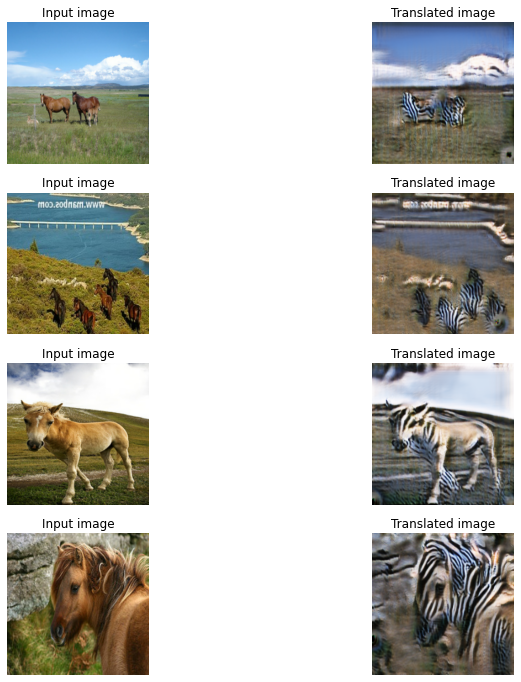

In [22]:
CURRENT_EPOCH = 1
EPOCHs = 50

SAVE_EVERY_N_EPOCH = 2

checkpoint_path = "./checkpoints3/train"
ckpt = tf.train.Checkpoint(generatorA=generatorA,
                           generatorB=generatorB,
                           discriminatorA=discriminatorA,
                           discriminatorB=discriminatorB,
                           gen_A_optimizer=gen_A_optimizer,
                           gen_B_optimizer=gen_B_optimizer,
                           disc_A_optimizer=disc_A_optimizer,
                           disc_B_optimizer=disc_B_optimizer
                           )
                           

# save model

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

print(ckpt_manager.checkpoints)
if ckpt_manager.latest_checkpoint:
    ckpt.restore('./checkpoints3/train/ckpt-23')
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))
    

for epoch in range(CURRENT_EPOCH, EPOCHs+1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    
    for step, (data_a, data_b) in enumerate(zip(train_horses, train_zebras)):
        train_step(data_a, data_b)
        
        if (step + 1) % 100 == 0:
            print("-", end=" ")
        
        if step > 500:
            break
    
        

    
    generate_and_save_images(epoch)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        #save model
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
          

generate_and_save_images(51)

(866, 1300, 3)


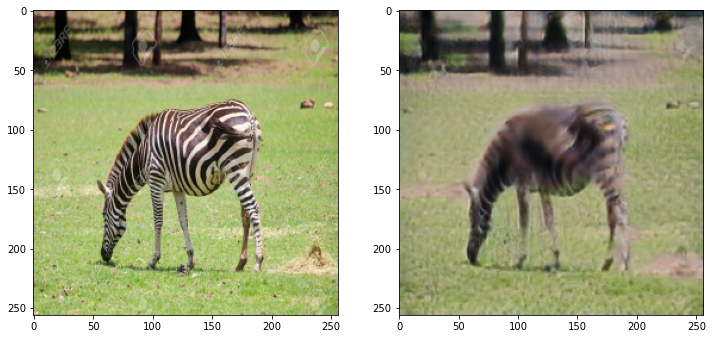

In [23]:
import cv2

img = cv2.imread("/Users/lubaixun/Downloads/70493313-sydney-australia-4-de-enero-de-2017-cebra-de-los-llanos-del-parque-zoológico-de-taronga-en-sydney-es.webp") 
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

img = (img - 127.5) / 127.5

img = np.expand_dims(img, axis=0)
prediction = generatorB(img)[0].numpy()

prediction = (prediction + 1.0) * 127.5
prediction = tf.cast(prediction, tf.uint8)

img = (img + 1.0) * 127.5
img = tf.cast(img, tf.uint8) 

_, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].imshow(img[0])
ax[1].imshow(prediction)


plt.show
plt.savefig("pictur6.jpg")